# Tu primera red neuronal 

En este proyecto, construirás tu primera red neuronal y la usarás para predecir el número de usuarios diarios de alquiler de bicicletas. Proporcionamos parte del código, pero dejamos la implementación de la red neuronal en tus manos (en su mayor parte). Una vez que hayas entregado este proyecto, no dudes en explorar más los datos y el modelo.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

c:\Users\comunicaciones\Anaconda3\envs\radeon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# comprobar si CUDA está disponible
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

False


## Cargar y preparar los datos

Un paso crítico para trabajar con redes neuronales es preparar los datos correctamente. Las variables en diferentes escalas dificultan que la red aprenda de manera eficiente los pesos correctos. A continuación, hemos escrito el código para cargar y preparar los datos. ¡Te invito a buscar más información!

In [3]:
data_path = 'C:/Users/comunicaciones/Documents/johan/Maestria/Aprendizaje profundo/Taller 1/hour.csv'

rides = pd.read_csv(data_path)

In [4]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Verificando los datos

Este conjunto de datos tiene el número de ciclistas para cada hora de cada día desde el 1 de enero de 2011 hasta el 31 de diciembre de 2012. El número de ciclistas se divide entre ocasionales y registrados, resumidos en la columna `cnt`. Puedes ver las primeras filas de los datos anteriores.

A continuación se muestra un gráfico que muestra el número de ciclistas durante los primeros 10 días en el conjunto de datos. (Algunos días no tienen exactamente 24 entradas en el conjunto de datos, por lo que no son exactamente 10 días). Puedes ver los alquileres por hora aquí. ¡Estos datos son bastante complicados! Los fines de semana tienen un menor número total de pasajeros y hay picos cuando las personas van y vienen del trabajo en bicicleta durante la semana. Al observar los datos anteriores, también tenemos información sobre la temperatura, la humedad y la velocidad del viento, que probablemente afecten la cantidad de ciclistas. Intentarás capturar todo esto con tu modelo.

<AxesSubplot:xlabel='dteday'>

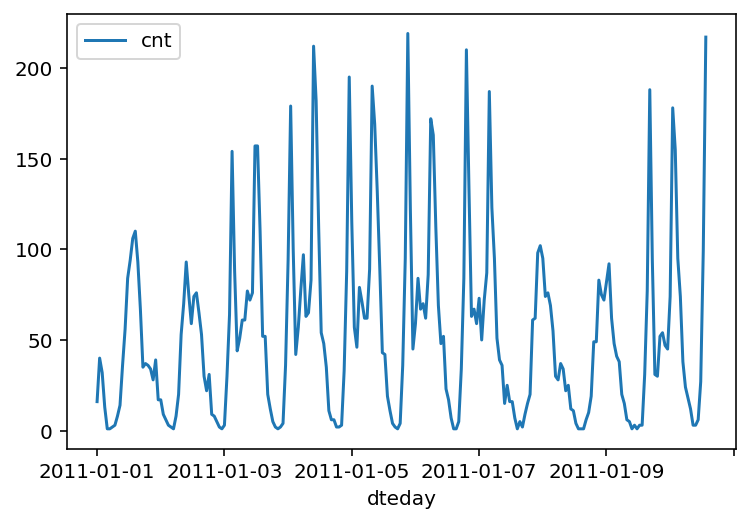

In [5]:
rides[:24*10].plot(x='dteday', y='cnt')

### Variables Dummy
Aquí tenemos algunas variables categóricas como estación, clima, mes. Para incluirlos en nuestro modelo, necesitaremos crear variables ficticias binarias. Esto es fácil de hacer con Pandas gracias a `get_dummies()`.

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Escalando variables
Para facilitar el entrenamiento de la red, estandarizaremos cada una de las variables continuas. Es decir, desplazaremos y escalaremos las variables de modo que tengan una media cero y una desviación estándar de 1.

Los factores de escala se guardan para que podamos retroceder cuando usamos la red para las predicciones.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Guarde las escalas en un diccionario para que podamos volver a convertirlas más tarde
scaled_features = {}

#### Aquí se elige un tipo de normalization. Se pueden normalizar los datos enbase al valor máximo o a la desviación estandar y al promedio.
#### En este caso se corre con la normalización recomendada por el docente mean_std:


In [ ]:
normalization = 'mean_std'

if normalization == 'mean_std':
    for each in quant_features:
        mean, std = data[each].mean(), data[each].std()
        scaled_features[each] = [mean, std]
        data.loc[:, each] = (data[each] - mean)/std
else:
    for each in quant_features:
        maxim = data[each].max()
        scaled_features[each] = maxim
        data.loc[:, each] = data[each]/maxim

In [8]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Guarde las escalas en un diccionario para que podamos volver a convertirlas más tarde
scaled_features = {}


"quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']\n# Guarde las escalas en un diccionario para que podamos volver a convertirlas más tarde\nscaled_features = {}\nfor each in quant_features:\n    maxim = data[each].max()\n    scaled_features[each] = maxim\n    data.loc[:, each] = data[each]/maxim"

In [9]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


### Dividir los datos en conjuntos de entrenamiento, prueba y validación

Guardaremos los datos de los últimos 21 días aproximadamente para usarlos como conjunto de prueba después de haber entrenado la red. Usaremos este conjunto para hacer predicciones y compararlas con el número real de ciclistas.

In [10]:
# Guardar datos de aproximadamente los últimos 21 días
test_data = data[-21*24:]

# Ahora elimine los datos de prueba del conjunto de datos 
data = data[:-21*24]

# Separar los datos en características y objetivos
target_fields = ['cnt']#, 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Dividiremos los datos en dos conjuntos, uno para el entrenamiento y otro para la validación a medida que se entrena la red. Dado que se trata de datos de series temporales, entrenaremos con datos históricos y luego intentaremos predecir con datos futuros (el conjunto de validación).

In [11]:
# Mantenga los últimos 60 días de los datos restantes como un conjunto de validación
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [12]:
data.head()


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


### Creación de Cargadores

De formato Pandas debemos cambiar nuestros datos a formato numpy

In [13]:
train_features_np = train_features.to_numpy()
val_features_np = val_features.to_numpy()
test_features_np = test_features.to_numpy()
train_targets_np = train_targets.to_numpy()
val_targets_np = val_targets.to_numpy()
test_targets_np = test_targets.to_numpy()

Creamos tensores

In [14]:
train_tensor = torch.tensor(train_features_np, dtype=torch.float)
val_tensor = torch.tensor(val_features_np, dtype=torch.float)
test_tensor = torch.tensor(test_features_np, dtype=torch.float)
train_targets_tensor = torch.tensor(train_targets_np, dtype=torch.float)
val_targets_tensor = torch.tensor(val_targets_np, dtype=torch.float)
test_targets_tensor = torch.tensor(test_targets_np, dtype=torch.float)

Definimos nuestro set de datos

In [15]:
# Define dataset
train_data = TensorDataset(train_tensor, train_targets_tensor)
valid_data = TensorDataset(val_tensor, val_targets_tensor)
test_data = TensorDataset(test_tensor, test_targets_tensor)

Creamos dataloaders

In [16]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size, shuffle=False)# shuffle=True)
valid_loader = DataLoader(valid_data, batch_size, shuffle=False)# shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)# shuffle=True)

## Hora de construir la red

A continuación, construirá su red. Hemos construido la estructura. Implementará tanto el pase hacia adelante como el pase hacia atrás a través de la red. También establecerá los hiperparámetros: la tasa de aprendizaje, la cantidad de unidades ocultas y la cantidad de pases de entrenamiento.

La red tiene x capas, x capas ocultas y una capa de salida. Las capas ocultas utilizarán la función relu para las activaciones. La capa de salida tiene solo un nodo y se usa para la regresión, la salida del nodo es la misma que la entrada del nodo. Es decir, la función de activación es $f(x)=x$. Una función que toma la señal de entrada y genera una señal de salida, pero tiene en cuenta el umbral, se denomina función de activación. Trabajamos a través de cada capa de nuestra red calculando las salidas para cada neurona. Todas las salidas de una capa se convierten en entradas para las neuronas de la siguiente capa. Este proceso se llama *forward propagation*.

Usamos los pesos para propagar señales hacia adelante desde la entrada a las capas de salida en una red neuronal. Usamos los pesos para propagar el error hacia atrás desde la salida a la red para actualizar nuestros pesos. Esto se llama *backpropagation*.



A continuación, tienes estas tareas:
1. Definir la arquitectura de tu red.
2. Definir la función de costo y el optimizador.
3. Entrenar el modelo.
4. Visualizar las curvas de costo de entrenamiento y validación para verificar si estamos "overfitting" o no.
5. Pasar los datos de testeo por el modelo pre-entrenado.
6. Descalar y Visualiza las curvas de las predicciones vs los valores reales
  

In [17]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([16, 58]) torch.Size([16, 1])


### 1- Definir la arquitectura de tu modelo

In [18]:
#Define la aquitectura
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(58, 128)
        self.fc2 = nn.Linear(128, 256) 
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 512)  
        self.fc6 = nn.Linear(512, 256)
        self.fc7 = nn.Linear(256, 128)  
        self.fc8  = nn.Linear(128,58)
        self.fc9  = nn.Linear(58,1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        x = F.relu(x)
        x = self.fc8(x)
        x = F.relu(x)
        x = self.fc9(x)
        return x

In [19]:
#Instancia tu modelo
model = Classifier()
print(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if train_on_gpu:
    model.cuda()

Classifier(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=256, bias=True)
  (fc7): Linear(in_features=256, out_features=128, bias=True)
  (fc8): Linear(in_features=128, out_features=58, bias=True)
  (fc9): Linear(in_features=58, out_features=1, bias=True)
)
cpu


## Entrenando la red

Aquí establecerás los hiperparámetros para la red. La estrategia aquí es encontrar hiperparámetros de modo que el error en el conjunto de entrenamiento sea bajo, pero no se esté sobreajustando a los datos. Si entrenas la red demasiado tiempo o tiene demasiados nodos ocultos, puede volverse demasiado específica para el conjunto de entrenamiento y no podrá generalizarse al conjunto de validación. Es decir, la pérdida en el conjunto de validación comenzará a aumentar a medida que disminuya la pérdida del conjunto de entrenamiento.

También utilizarás un método conocido como Stochastic Gradient Descent (SGD) para entrenar la red. La idea es que para cada pase de entrenamiento, tome una muestra aleatoria de los datos en lugar de usar todo el conjunto de datos. Utiliza muchas más pasadas de entrenamiento que con el normal gradient descent, pero cada pasada es mucho más rápida. Esto termina entrenando la red de manera más eficiente. 

### Elija el número de iteraciones (epócas)
Este es el número de lotes de muestras de los datos de entrenamiento que usaremos para entrenar la red. Cuantas más iteraciones utilices, mejor se ajustará el modelo a los datos. Sin embargo, este proceso puede tener rendimientos decrecientes y puede desperdiciar recursos computacionales si utiliza demasiadas iteraciones. Aquí deseas encontrar un número en el que la red tenga una pérdida de entrenamiento baja y la pérdida de validación sea mínima. El número ideal de iteraciones sería un nivel que se detenga poco después de que la pérdida de validación deje de disminuir.

### Elija la tasa de aprendizaje
Esto escala el tamaño de las actualizaciones de peso. Si es demasiado grande, los pesos tienden a explotar y la red no logra ajustar los datos. Normalmente, una buena opción para empezar es 0.1. Si la red tiene problemas para ajustar los datos, intenta reducir la tasa de aprendizaje. Ten en cuenta que cuanto menor sea la tasa de aprendizaje, menores serán los pasos en las actualizaciones de peso y más tiempo tardará la red neuronal en converger.

### Elige el número de nodos ocultos
En un modelo donde todos los pesos están optimizados, cuantos más nodos ocultos tenga, más precisas serán las predicciones del modelo. Sin embargo, cuantos más nodos ocultos tenga, más difícil será optimizar los pesos del modelo y más probable será que los pesos subóptimos conduzcan a sobreajuste. Con el sobreajuste, el modelo memorizará los datos de entrenamiento en lugar de aprender el patrón verdadero y no generalizará bien a los datos no vistos.

Prueba algunos números diferentes y mira cómo afecta el rendimiento. Si el número de unidades ocultas es demasiado bajo, el modelo no tendrá suficiente espacio para aprender y si es demasiado alto, habrá demasiadas opciones para la dirección que puede tomar el aprendizaje. El truco aquí es encontrar el equilibrio correcto en la cantidad de unidades ocultas que elijas. En general, encontrará que la mejor cantidad de nodos ocultos para usar termina estando entre la cantidad de nodos de entrada y salida.

### 2- Define la función de costo y el optimizador
Recuerda que es un problema de regresión

In [20]:
#Define la función de costo
criterion = nn.MSELoss()
#Define el optimizador
optimizer = optim.Adam(model.parameters(), lr = 1e-3)


### 3- Entrena el modelo
Recuerda que aquí puedes usar la técnica "stop learning" (revisa los cuadernos de las clases)

In [22]:
# Número de épocas del modelo
n_epochs = 25

valid_loss_min = np.Inf # Valor inicial de la función de pérdida
train_graph=[]
valid_graph=[]

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    ############################
    # Entrenamiento del modelo #
    ############################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Se pasan os tensores a GPU si están disponibles
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Se reinician los gradientes
        optimizer.zero_grad()
        # Predicción
        output = model(data)
        # Cálculo de la función de pérdida
        loss = criterion(output, target)
        # Computariza los gradientes
        loss.backward()
        # Actualiza los pesos
        optimizer.step()
        # Acumula la función de pérdida
        train_loss += loss.item()*data.size(0)
        
    #########################    
    # Validación del modelo #
    #########################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # Se cálcula la media de la función de pérdida
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_graph.append(train_loss)
    valid_graph.append(valid_loss)  
    # Muestra de datos
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    #Se guarda el mejor modelo
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.037901 	Validation Loss: 0.052329
Validation loss decreased (inf --> 0.052329).  Saving model ...
Epoch: 2 	Training Loss: 0.014202 	Validation Loss: 0.012041
Validation loss decreased (0.052329 --> 0.012041).  Saving model ...
Epoch: 3 	Training Loss: 0.012942 	Validation Loss: 0.002608
Validation loss decreased (0.012041 --> 0.002608).  Saving model ...
Epoch: 4 	Training Loss: 0.011769 	Validation Loss: 0.277009
Epoch: 5 	Training Loss: 0.007217 	Validation Loss: 0.002336
Validation loss decreased (0.002608 --> 0.002336).  Saving model ...
Epoch: 6 	Training Loss: 0.007915 	Validation Loss: 0.121958
Epoch: 7 	Training Loss: 0.008227 	Validation Loss: 0.003078
Epoch: 8 	Training Loss: 0.007662 	Validation Loss: 0.003428
Epoch: 9 	Training Loss: 0.005431 	Validation Loss: 0.019589
Epoch: 10 	Training Loss: 0.003810 	Validation Loss: 0.006003
Epoch: 11 	Training Loss: 0.005054 	Validation Loss: 0.027671
Epoch: 12 	Training Loss: 0.005795 	Validation Loss: 0.0

### 4- Visualiza las cuevas de error de entrenamiento y validación

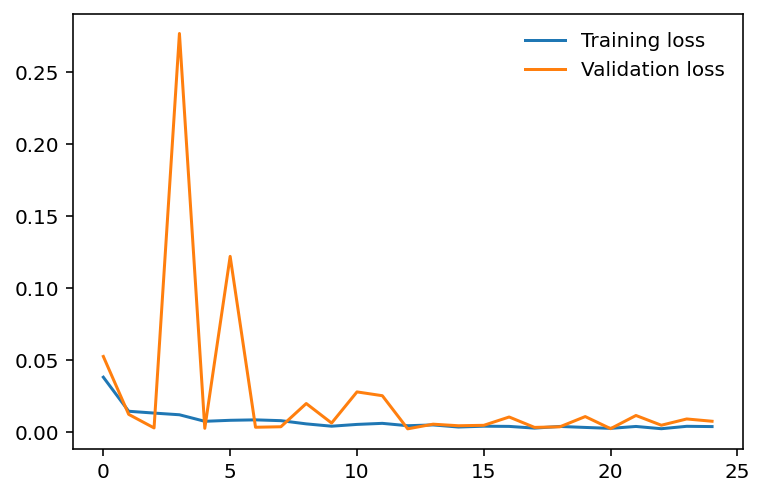

In [23]:
#Visualiza los errores de entrenamiento y validación
plt.plot(train_graph, label='Training loss')
plt.plot(valid_graph, label='Validation loss')
plt.legend(frameon=False)

## 5- Consulta tus pronósticos

Aquí, usa los datos de testeo para ver qué tan bien tu red está modelando los datos. Si algo está completamente mal aquí, asegúrate de que cada paso en tu red se implemente correctamente.

In [24]:
#Pasa los datos de testeo por tu modelo pre-entrenado
state_dict = torch.load('model_augmented.pt')
print(state_dict.keys())
model.load_state_dict(state_dict)
print(model)
predictions=[]
test_loss=0.0
model.eval()
for batch_idx, (data, target) in enumerate(test_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        if train_on_gpu:
            predictions=predictions+output.cpu().tolist()
        else:
            predictions=predictions+output.tolist()
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
    
test_loss = test_loss/len(test_loader.sampler)


odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias', 'fc7.weight', 'fc7.bias', 'fc8.weight', 'fc8.bias', 'fc9.weight', 'fc9.bias'])
Classifier(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=256, bias=True)
  (fc7): Linear(in_features=256, out_features=128, bias=True)
  (fc8): Linear(in_features=128, out_features=58, bias=True)
  (fc9): Linear(in_features=58, out_features=1, bias=True)
)


### 6- Descalar y Visualiza las curvas de las predicciones vs los valores reales

Según los resultados obtenidos, se concluye que el modelo de prediccón es adecuado para obtener los valores requeridos, ya que los valores predichos se acercan mucho a los valores reales.

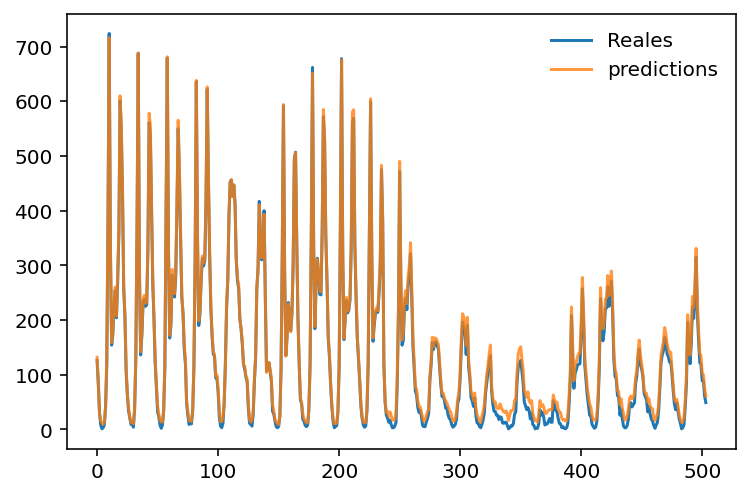

In [51]:
if normalization == 'mean_std':
    scaled_predictions=np.asarray(predictions)*scaled_features['cnt'][1] + scaled_features['cnt'][0] 
    plt.plot(test_targets_np*scaled_features['cnt'][1] + scaled_features['cnt'][0], label='Reales')
    plt.plot(scaled_predictions, label='predictions', alpha = 0.8)
    plt.legend(frameon=False)
else:
    scaled_predictions=np.squeeze(np.asarray(predictions))*scaled_features['cnt']
    plt.plot(scaled_predictions, label='predictions')
    plt.plot(test_targets_np*scaled_features['cnt'], label='Reales')
    plt.legend(frameon=False)
